In [1]:
import numpy as np
import pandas as pd
import joblib
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from matplotlib import pyplot as plt

In [2]:
def create_multivariate_time_series(data, n_past, target_col=0, feature_cols=None):
    if feature_cols is None:
        feature_cols = list(range(data.shape[1]))

    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, feature_cols])
        y.append(data[i, target_col])

    return np.array(X), np.array(y)

In [3]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.0))
    model.add(LSTM(32))
    model.add(Dropout(0.0))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [4]:
df = pd.read_csv("../data/processed/mbajk_processed.csv")
df.head()

,available_bike_stands,surface_pressure,temperature,apparent_temperature,relative_humidity,date
0,7,984.45,24.425,23.65,43.5,2023-06-25 19:00:00+00:00
1,8,984.45,22.850,22.50,49.0,2023-06-25 20:00:00+00:00
2,4,984.55,20.950,21.05,56.5,2023-06-25 21:00:00+00:00
3,0,985.00,19.520,19.45,65.0,2023-06-25 22:00:00+00:00
4,0,985.25,18.000,18.30,73.0,2023-06-25 23:00:00+00:00


In [5]:
target = "available_bike_stands"
features = [target] + [col for col in df.columns if col != target and col != "date"]

dataset = df[features]

In [6]:
test_split = round(len(dataset) * 0.2)

train_data = dataset[:-test_split]
test_data = dataset[-test_split:]

print(train_data.shape, test_data.shape)

(1875, 5) (469, 5)


In [7]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [8]:
window_size = 48

target_col_idx = df.columns.get_loc(target)
feature_cols_idx = [df.columns.get_loc(col) for col in features]

In [9]:
X_train, y_train = create_multivariate_time_series(train_data, window_size, target_col_idx, feature_cols_idx)
X_test, y_test = create_multivariate_time_series(test_data, window_size, target_col_idx, feature_cols_idx)

print(f"Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of training data: X_train: (1827, 48, 5), y_train: (1827,)
Shape of testing data: X_test: (421, 48, 5), y_test: (421,)


In [10]:
input_shape = (X_train.shape[1], X_train.shape[2])

models = [build_lstm_model(input_shape)]

history = {}

C:\Users\jerne\AppData\Local\pypoetry\Cache\virtualenvs\napovedna-storitev-qvy3MJFM-py3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
for model in models:
    print(f"Training {model.name} model")
    fit_result = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), verbose=1)
    history[model.name] = fit_result.history

Training sequential model
Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.2426 - val_loss: 0.0948
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0690 - val_loss: 0.0832
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0543 - val_loss: 0.0708
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0439 - val_loss: 0.0543
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0363 - val_loss: 0.0506
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0305 - val_loss: 0.0452
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0279 - val_loss: 0.0390
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0240 - val_loss: 0.0384
Epoch 9/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0249 - val_loss: 0.0349
Epoch 10/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0201 - val_loss: 0.0305
Epoch 11/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0196 - val_loss: 0.0292
Epoch 12/15
29/29 ━━━━━━━━━━━━━━━━━━━

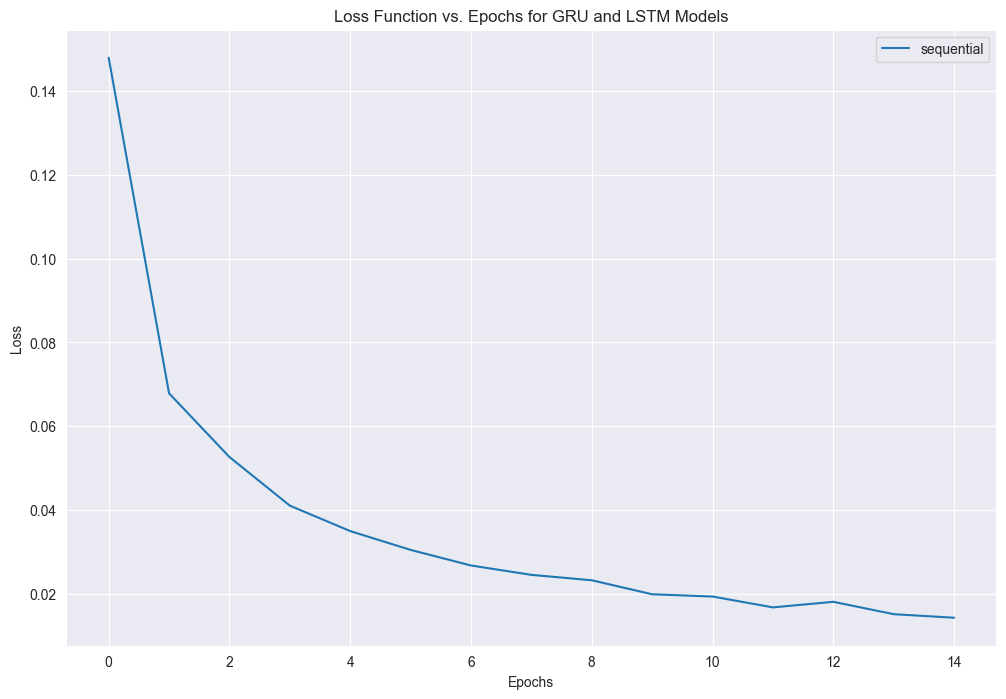

In [12]:
plt.figure(figsize=(12, 8))
for name, values in history.items():
    plt.plot(values['loss'], label=name)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs for GRU and LSTM Models')
plt.legend()
plt.show()

In [13]:
y_test_copy = np.repeat(y_test, dataset.shape[1], axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copy, (len(y_test), dataset.shape[1])))[:, 0]

In [14]:
results = {
    "MAE": [],
    "MSE": [],
    "EVS": []
}

for model in models:
    predicted = model.predict(X_test)

    prediction_copies = np.repeat(predicted, dataset.shape[1], axis=-1)
    predicted = scaler.inverse_transform(np.reshape(prediction_copies, (len(predicted), dataset.shape[1])))[:, 0]

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)

    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
sequential - MSE: 10.56
sequential - MAE: 2.37
sequential - EVS: 0.78


In [15]:
prediction = models[0].predict(X_test)
prediction_copy_array = np.repeat(prediction, dataset.shape[1], axis=-1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [16]:
pred = scaler.inverse_transform(np.reshape(prediction_copy_array, (len(prediction), dataset.shape[1])))[:, 0]
dates = df['date'].values
df_output = pd.DataFrame({"date": dates[-test_split + window_size:], 'Actual': y_test, 'Predicted': pred})
df_output.head(20)

,date,Actual,Predicted
0,2023-09-16 03:00:00+00:00,16.0,15.898806
1,2023-09-16 04:00:00+00:00,16.0,16.022297
2,2023-09-16 05:00:00+00:00,18.0,16.278961
3,2023-09-16 06:00:00+00:00,21.0,17.937836
4,2023-09-16 07:00:00+00:00,21.0,20.388260
5,2023-09-16 08:00:00+00:00,20.0,20.813900
6,2023-09-16 09:00:00+00:00,21.0,19.991663
7,2023-09-16 10:00:00+00:00,21.0,20.226759
8,2023-09-16 11:00:00+00:00,17.0,20.150723
9,2023-09-16 12:00:00+00:00,19.0,17.265509


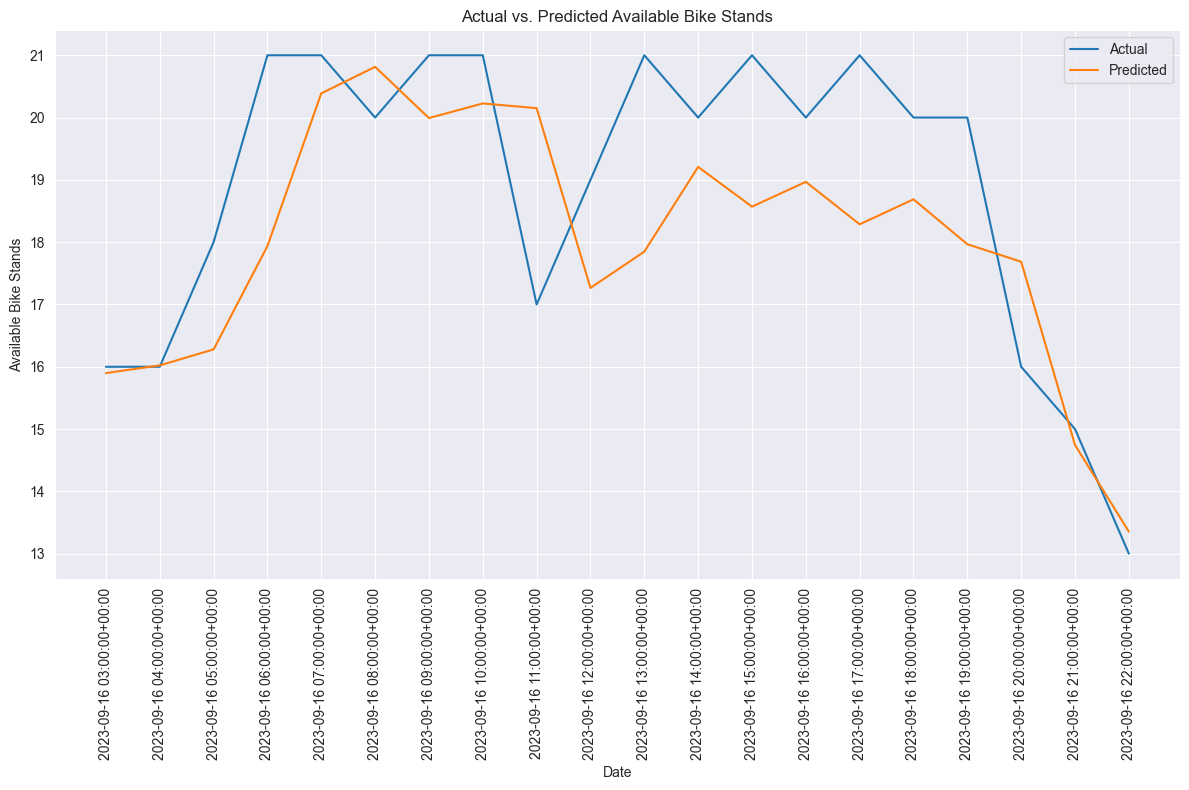

In [17]:
def plot_results(df):
    plt.figure(figsize=(12, 8))
    plt.plot(df['date'], df['Actual'], label="Actual")
    plt.plot(df['date'], df['Predicted'], label="Predicted")
    plt.xlabel('Date')
    plt.ylabel('Available Bike Stands')
    plt.title('Actual vs. Predicted Available Bike Stands')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_results(df_output.head(20))

In [18]:
best_model = None
min_mse = float('inf')
for m in models:
    mse = results['MSE'][0][1]
    if mse < min_mse:
        min_mse = mse
        best_model = m

In [19]:
joblib.dump(scaler, "../models/minmax_scaler.gz")
best_model.save(f"../models/mbajk_{best_model.name}_mse_{format(min_mse, ".2f")}.keras")